In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
from UrnGame import *

# Normative Inference form Causal Explanation
### Nicolas Navarre

In this document I will attempt to outline a normative model of inference from explanation. I will be working from the four-urns scenario where the presence of a coloured or uncoloured ball from each of the balls determines the outcome of a game given a known rule.

There are 3 conditions of evidence that can be provided
1. Observations with no explanation
2.  Observations with any causal explanation
3.  Observations with *the* causal explanation

I will be comparing this with two likelihood models for the explanation
- Necessity and Sufficiency Model
- Counterfactual Effect Size Model
  

## Modelling the game

There are 4 urns with two possible states. This leaves us with $2^4=16$ possible worlds. Moreover, the set of propositions is $2^{2^4} = 65536$. Thus, the probability of guessing the right (semantic) rule as zero-shot is $\frac{1}{65365}$.

In [3]:
urn_priors = np.array([0.9, 0.6, 0.4, 0.1]) # A high, B: medium, C: medium , D: low
urns = UrnGame(n_urns=4,urn_probs=urn_priors)

### Possible worlds

In this game we have four urns each with their own probabilities.


In [4]:
possible_worlds = urns.get_all_worlds()

world_priors = np.zeros(16)
for idx,world in enumerate(possible_worlds):
    sample_probabilities = [urn_priors[idx] if urn else (1-urn_priors[idx]) for idx,urn in enumerate(world)]
    world_priors[idx] = np.prod(sample_probabilities)

n_worlds = len(possible_worlds)
possible_worlds

array([[0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 1.],
       [0., 1., 1., 0.],
       [0., 1., 1., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 1.],
       [1., 0., 1., 0.],
       [1., 0., 1., 1.],
       [1., 1., 0., 0.],
       [1., 1., 0., 1.],
       [1., 1., 1., 0.],
       [1., 1., 1., 1.]])

### Propositions: $\mathbf{\Theta}$

Since there are only 16 possible worlds per proposition, we can order all possible worlds from 1 to 16. Each proposition will differ in the combination of outcomes across all possible worlds.
Each of the possible worlds can be an index in a vector where the value of the vector is the valuation of that possible world in the given proposition.

$$
p_0 = \langle 0,0,0,\dots, 0 ,0 \rangle
$$
$$
p_1 = \langle 0,0,0,\dots, 0, 1 \rangle
$$
$$
p_2 = \langle 0,0,0,\dots, 1, 0 \rangle
$$
$$
\vdots
$$
$$
p_{65535} = \langle 1,1,1,\dots, 1,1 \rangle
$$


In [5]:
propositions = urns.get_all_propositions()
propositions.shape

(65536, 16)

In [6]:
# save total number of propositions
n_props = len(propositions)

# To reverse search the proposition number
propositions_map = {tuple(propositions[i]):i  for i in range(len(propositions))}

def get_proposition_num(proposition):
    return propositions_map[tuple(proposition)]
def get_proposition_string(prop_num):
    return "".join([str(w) for w in propositions[prop_num]])

In [7]:
def c_and_d(world):
    return (world[2] and world[3]) 

def c_or_d(world):
    return (world[2] or world[3]) 

def at_least_2(world):
    return sum(world)>=2

def all_present(world):
    return all(world)

## Simplicity Prior: $P(\mathbf{\Theta})$

In order to make our normative model normalizable and realistic, lets assume a simplicity prior over propositions.
We define a simple proposition as one that has the amount of variables that covary with the outcome across the possible worlds.

Now we want to compute the correlation that each column of the possible worlds has with the poutcome defined by the possible world.
For every proposition, we will get a 4-tuple with a correlation score for each urn.

### PCFG Prior

This prior is generated by counting the number of instances of semantic rules generated from a PCFG Prior.
Refer to the code documentation of the PCFG implemented in the Rust programming language.

We add a softmax with temperature as a free parameter to the model.

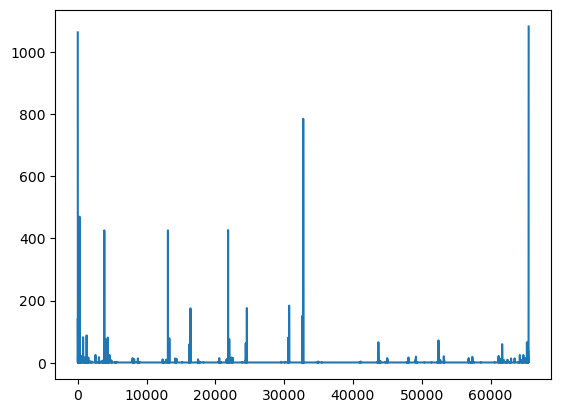

In [8]:
pcfg_counts = np.load('UrnGame/pcfg_prior.npy')
plt.plot(pcfg_counts)

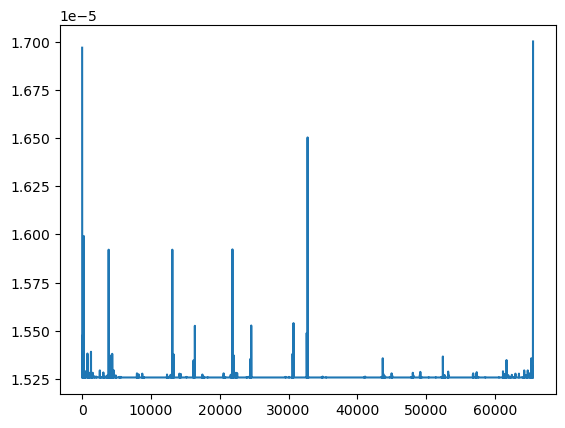

In [9]:
tau_pcfg = 10**4
pcfg_exp_counts = np.exp(np.array(pcfg_counts)/tau_pcfg)
pcfg_prior = pcfg_exp_counts/sum(pcfg_exp_counts)
plt.plot(pcfg_prior)

### Even prior

In [10]:
even_prior = np.ones(n_props)/n_props

## Observations

Given a proposition and a sample from the urns as a possible world we get an observation.
This essentially a tuple of information including the input and oucome of the system.
Since the outcome of each possible world is binary, the number of total possible observations is twice the number of possible worlds.

Since each observation depends on a proposition and a sample from the urns we can give the following definition for the probability of each observation.

$$
P(O) = \sum_{W \in \mathbf{W}}\sum_{\Theta \in \mathbf{\Theta}} P(O|W,\Theta)P(W)P(\Theta) 
$$

In [11]:
observations = [(w,i) for w in range(n_worlds) for i in range(2)]
p_observations = { obs:0 for obs in observations}

In [12]:
for w in range(n_worlds):
    for prop in range(len(propositions)):
        p_observations[(w,propositions[prop][w])] += world_priors[w]*even_prior[prop]

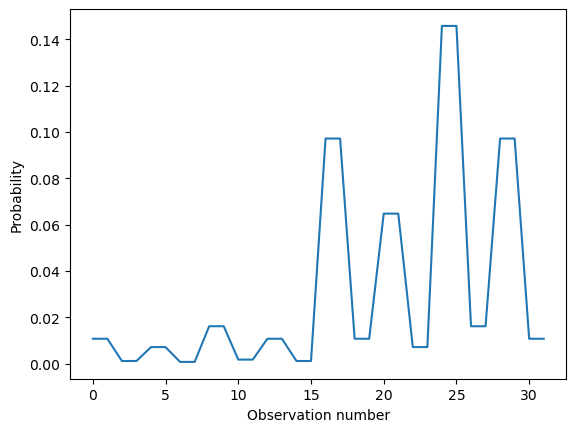

In [13]:
plt.plot(p_observations.values())
plt.ylabel('Probability')
plt.xlabel('Observation number')
plt.show()

# Inference model

The goal of the agent is to infer the right proposition based on the observation of four possible worlds and their outcomes.

let $\mathbf{\Theta}$ be the set of all propositions and $\hat{\Theta}$ is the rule we are after.

A set of observations $\mathbf{O}$ may or may not be compatible with a given proposition $\Theta \in \mathbf{\Theta}$. 
This will be defined by the likelihood function $P(O|\Theta)$

$$
P(\Theta|\mathbf{O}) = \prod_{O \in \mathbf{O}}\frac{ P(O|\Theta)P(\Theta)}{P(O)}
$$



In [14]:
# Normative observation likelihood function (proxy for logical deductive reasoning)
def observation_likelihood(obs,prop):
    return abs(propositions[prop][obs[0]]== obs[1]) 

# Some noise, but this would likely be best introduced later as a free parameter to fit data
def observation_likelihood_noisy(obs,prop):
    return abs(int(propositions[prop][obs[0]]== obs[1])-0.05) # Introduce the small margin of uncertainty

## Inference from Observations

In [15]:
def ad_c(world):
    """Rule for A and D or C
    """
    return (world[0] and world[3]) or world[2]

In [16]:
# find the proposition number for this rule (useful for comparisons later)
ad_c_num = get_proposition_num([ad_c(world) for world in possible_worlds])


In [17]:
# Define worlds shown in the experiment
sample_data = [
    [0,1,0,0],
    [1,0,1,0],
    [1,1,0,0],
    [1,1,1,1]]

# Define observations
observation_data = [(urns.get_world_number(world),ad_c(world)) for world in sample_data]

In [18]:
def observation_posterior(prior,observation):
    """
    Computes the posterior of the observations
    """
    proposition_probs = np.zeros(n_props)
    for i in range(n_props):
        proposition_probs[i] = prior[i]*observation_likelihood(observation,i)
    return proposition_probs / sum(proposition_probs)

In [19]:
def compute_experiment_observations(prior,obs_data):
    num_obs = len(obs_data)
    posteriors = np.zeros((num_obs+1,n_props))
    posteriors[0] = prior
    for i in range(num_obs):
        posteriors[i+1] = observation_posterior(posteriors[i],obs_data[i])
    return posteriors

In [20]:
observation_even = compute_experiment_observations(even_prior,observation_data)
observation_pcfg = compute_experiment_observations(pcfg_prior,observation_data)

In [21]:
def plot_posteriors(inference_data):
    fig,ax = plt.subplots(nrows=1,ncols=len(inference_data),figsize=(15,3))
    
    for ci,col in enumerate(ax):
        col.plot(inference_data[ci])
        # col.set_ylim([0,.1])
    fig.show()

/var/folders/cg/49fv39xs0w7b42v0thstyfvw0000gq/T/ipykernel_93374/2556698328.py:7: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


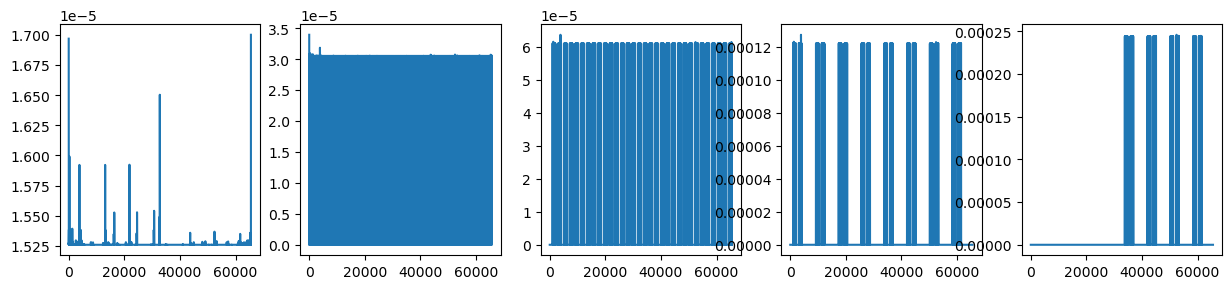

In [22]:
plot_posteriors(observation_pcfg)

## Inference from Explanations

We need to also include the explanations as evidence for the model.

$$
P(\Theta | O,E) =  \frac{P(O,E|\Theta)P(\Theta)}{P(O,E)}
$$

$$
P(\Theta| O,E) = \frac{P(E|O,\Theta)P(O|\Theta)P(\Theta)}{P(O,E)}
$$


### New normalization

$$
P(O,E) = \sum_{\Theta' \in \mathbf{\Theta}} P(O,E|\Theta')P(\Theta') = \sum_{\Theta' \in \mathbf{\Theta}} P(E|O,\Theta')P(O|\Theta')P(\Theta')
$$

Since there are four urns we can possibly select as the cause of some observation $O$, then the set of possible explanations is 16 including the empty set (the case where no variables were responsible for the outcome.

So based on the counterfactual model of explanation, we need to give a likelihood score of each of the sets of variables that would explain observation $O$.

## Explanations

Create the set of all candidate selections

In [23]:
explanations = urnUtils.powerset([0,1,2,3])[1:]
explanations

[[0],
 [1],
 [0, 1],
 [2],
 [0, 2],
 [1, 2],
 [0, 1, 2],
 [3],
 [0, 3],
 [1, 3],
 [0, 1, 3],
 [2, 3],
 [0, 2, 3],
 [1, 2, 3],
 [0, 1, 2, 3]]

## Necessity and Sufficiency Model

Here we will be defining the likelihood of an explanation given the proposition $P(E|O,\Theta)$.

What is the probability we give a certain explanation gien the obesrvation and proposition?
For this we need to set the full set of possible explanations.
Since there are 4 urns and we may select any subset of those four as a causal explanation, the full set is one of the elements of the powerset of the urns. In total that gives 16 possible explanations.

In this counterfactual similation model, the likelihood is dependent on the necessity and sufficiency measures:

$$
\kappa(\vec{X},Y) = P(\vec{X} = \vec{x}')P^\nu_{\vec{X} \leftarrow \vec{x}'}(Y\neq y*) +  
P(\vec{X} = \vec{x}*)P^\sigma_{Y \neq y*, \vec{X} = \vec{x}',\vec{X} \leftarrow \vec{x}^*}(Y = y*)
$$

We can use this measure as out likelihood of the explanation $\vec{X} \in \mathbf{E}$ given an observation with outcome $(\mathbf{X},Y) \in \mathbf{O} $ and a candidate proposition $\Theta \in \mathbf{\Theta}$.

In [24]:
nsm = NSM(urnGame=urns)

### Example of NSM

Calculate the causal score of each possible explanation in every possible observations

/var/folders/cg/49fv39xs0w7b42v0thstyfvw0000gq/T/ipykernel_93374/3425887180.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


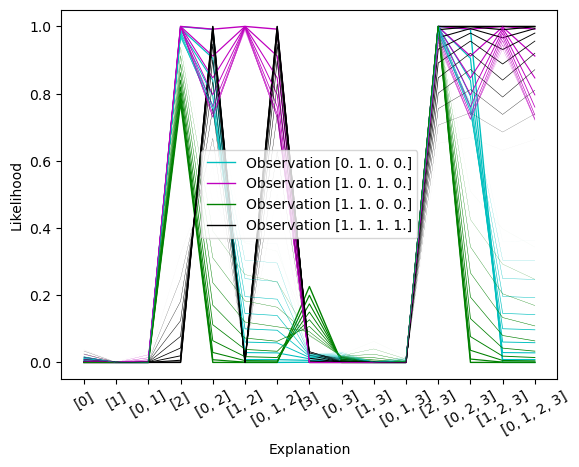

In [ ]:
cols = ['c','m','g','k']

fig, ax = plt.subplots()

s_vals = np.flip(np.linspace(0.01,.99,10))
lines = [None]*len(observation_data)
for s in s_vals:
    for i,ll in enumerate([nsm.get_causal_judgement(obs,propositions[ad_c_num],s=s) for obs in observation_data]):
        if s==s_vals[0]:
            lines[i], = ax.plot(ll,color=cols[i],lw=s,label=f'Observation {urns.get_world(observation_data[i][0])}')
        else:
            ax.plot(ll,color=cols[i],lw=s)        

ax.legend(
    # [f'obs-{i}' for i in range(len(lines))],
    # [f'Observation {urns.get_world(obs[0])}' for obs in observation_data]
)
ax.set_xlabel('Explanation')
ax.set_ylabel('Likelihood')
ax.set_xticks(np.arange(15))
ax.set_xticklabels(explanations,rotation=30)
fig.show()        

## Counterfactual Effect Size Model

In [28]:
cesm = CESM(urns)

### Example of CESM

/var/folders/cg/49fv39xs0w7b42v0thstyfvw0000gq/T/ipykernel_93374/1379866303.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


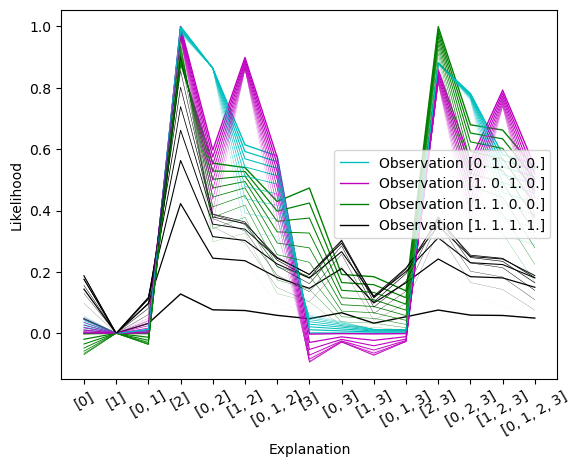

In [33]:
cols = ['c','m','g','k']

fig, ax = plt.subplots()

s_vals = np.flip(np.linspace(0.01,.99,10))
lines = [None]*len(observation_data)
for s in s_vals:
    for i,ll in enumerate([cesm.get_causal_judgement(obs,propositions[ad_c_num],s=s) for obs in observation_data]):
        if s==s_vals[0]:
            lines[i], = ax.plot(ll,color=cols[i],lw=s,label=f'Observation {urns.get_world(observation_data[i][0])}')
        else:
            ax.plot(ll,color=cols[i],lw=s)        

ax.legend(loc='right'
    # [f'obs-{i}' for i in range(len(lines))],
    # [f'Observation {urns.get_world(obs[0])}' for obs in observation_data]
)
ax.set_xlabel('Explanation')
ax.set_ylabel('Likelihood')
ax.set_xticks(np.arange(15))
ax.set_xticklabels(explanations,rotation=30)
fig.show()        

## Experiment Model with explanations
Now that we have defined the likelihood function we can evaluate the model on any proposition.

In [ ]:
# Define explanations
explanation_data = [explanations.index([2])] + [explanations.index([2])] + [explanations.index([2,3])] + [explanations.index([2])]

ac_exps_1 = [[0,2],[0],[3],[0,3],[0,2,3]]
ac_exps_2 = [[0,2]]
ac_exps_3 = [[2],[3]]
ac_exps_4 = [[0],[3],[0,2],[0,3],[2,3],[0,2,3]]

# Define null explanations
# All possible combinations as we gave to participants in the experiment
null_data = []
for e1 in ac_exps_1:
    for e2 in ac_exps_2:
        for e3 in ac_exps_3:
            for e4 in ac_exps_4:
                null_explanation_data = null_data.append([explanations.index(l) for l in [e1,e2,e3,e4]])

In [34]:
def explanation_likelihood(observation,proposition,model,s=0.7,gamma=1,w=0,norm=False):        
    explanation_strength = model.get_causal_judgement(observation,proposition,s=s,gamma=gamma,w=w)
    norm = np.linalg.norm(explanation_strength,1)
    if norm == 0:
        return explanation_strength
    else:
        return explanation_strength/norm

def explanation_posterior(prior,observation,explanation,model,s=0.7,gamma=1,w=0,verbose=False):
    props = propositions
    actual_world = possible_worlds[observation[0]]
    proposition_probs = np.zeros(len(props))
    for idx,prop in enumerate(props):
        obs_l = observation_likelihood(observation,prop)
        exp_l = explanation_likelihood(actual_world,prop,model,s=s,gamma=gamma,w=w)[explanation]
        proposition_probs[idx] = prior[idx]*obs_l*exp_l
        if verbose:
            if idx % 20000 == 0:
                print(f'Seen: {idx} examples.')
    return proposition_probs / sum(proposition_probs)


In [ ]:
def compute_experiment(prior,obs_data,exp_data,model,
                        s=0.7,
                        gamma=1,
                        w=0,
                        filename='CESM',
                        save_file = False,
                        verbose=True):                
                                   
    num_obs = len(obs_data)
    if num_obs != len(exp_data):
        return
    posteriors = np.zeros((num_obs+1,n_props))
    posteriors[0] = prior
    for i in range(num_obs):
        if verbose:
            print('Taking observation: ', obs_data[i])
        posteriors[i+1] = explanation_posterior(posteriors[i],obs_data[i],exp_data[i],model,s=s,gamma=gamma,w=w,verbose=verbose)
        if save_file:
            np.save(filename,posteriors)
    return posteriors


In [ ]:
def CESM_posterior(prior,observation,explanation,verbose=False):
    props = propositions
    actual_world = possible_worlds[observation[0]]
    proposition_probs = np.zeros(len(props))
    t = time.time()
    for idx,prop in enumerate(props):
        proposition_probs[idx] = prior[idx]*observation_likelihood(observation,prop)*CESM_likelihood(actual_world,prop)[explanation]
        if verbose:
            if idx % 20000 == 0:
                print(f'Seen: {idx} examples. Time elapsed: {time.time()-t}')
                t = time.time()
    return proposition_probs / sum(proposition_probs)


In [ ]:
def CESM_likelihood(obs,proposition,norm=False):
    explanation_strength = cesm.get_causal_judgement(obs,proposition,s=s)
    norm = np.linalg.norm(explanation_strength,1)
    if norm == 0:
        return explanation_strength
    else:
        return explanation_strength/norm

def CESM_posterior(prior,observation,explanation,verbose=False):
    props = propositions
    actual_world = possible_worlds[observation[0]]
    proposition_probs = np.zeros(len(props))
    t = time.time()
    for idx,prop in enumerate(props):
        proposition_probs[idx] = prior[idx]*observation_likelihood(observation,prop)*CESM_likelihood(actual_world,prop)[explanation]
        if verbose:
            if idx % 20000 == 0:
                print(f'Seen: {idx} examples. Time elapsed: {time.time()-t}')
                t = time.time()
    return proposition_probs / sum(proposition_probs)

def compute_experiment_CESM_observations(prior,obs_data,exp_data,filename='CESM',verbose=True):
    num_obs = len(obs_data)
    if num_obs != len(exp_data):
        return
    posteriors = np.zeros((num_obs+1,n_props))
    posteriors[0] = prior
    for i in range(num_obs):
        if verbose:
            print('Taking observation: ', obs_data[i])
        posteriors[i+1] = CESM_posterior(posteriors[i],obs_data[i],exp_data[i],verbose=verbose)
        np.save(filename,posteriors)
    return posteriors


In [ ]:
[explanations[exp] for exp in [np.argmax(CESM_likelihood(world,propositions[ad_c_num]))  for world in possible_worlds[[obs[0] for obs in observation_data]]]]

[[2], [2], [2, 3], [2]]

In [ ]:
(CESM_likelihood(possible_worlds[observation_data[2][0]],propositions[ad_c_num])).sum()

1.0

In [ ]:
NSM_L = [NSM_likelihood(obs,propositions[ad_c_num]) for obs in all_observations]
NSM_2_L = [NSM_likelihood_2(obs,propositions[ad_c_num]) for obs in all_observations]
CESM_L = [CESM_likelihood(world,propositions[ad_c_num])  for world in possible_worlds]

In [ ]:
observation_data

[(4, 0), (10, 1), (12, 0), (15, 1)]

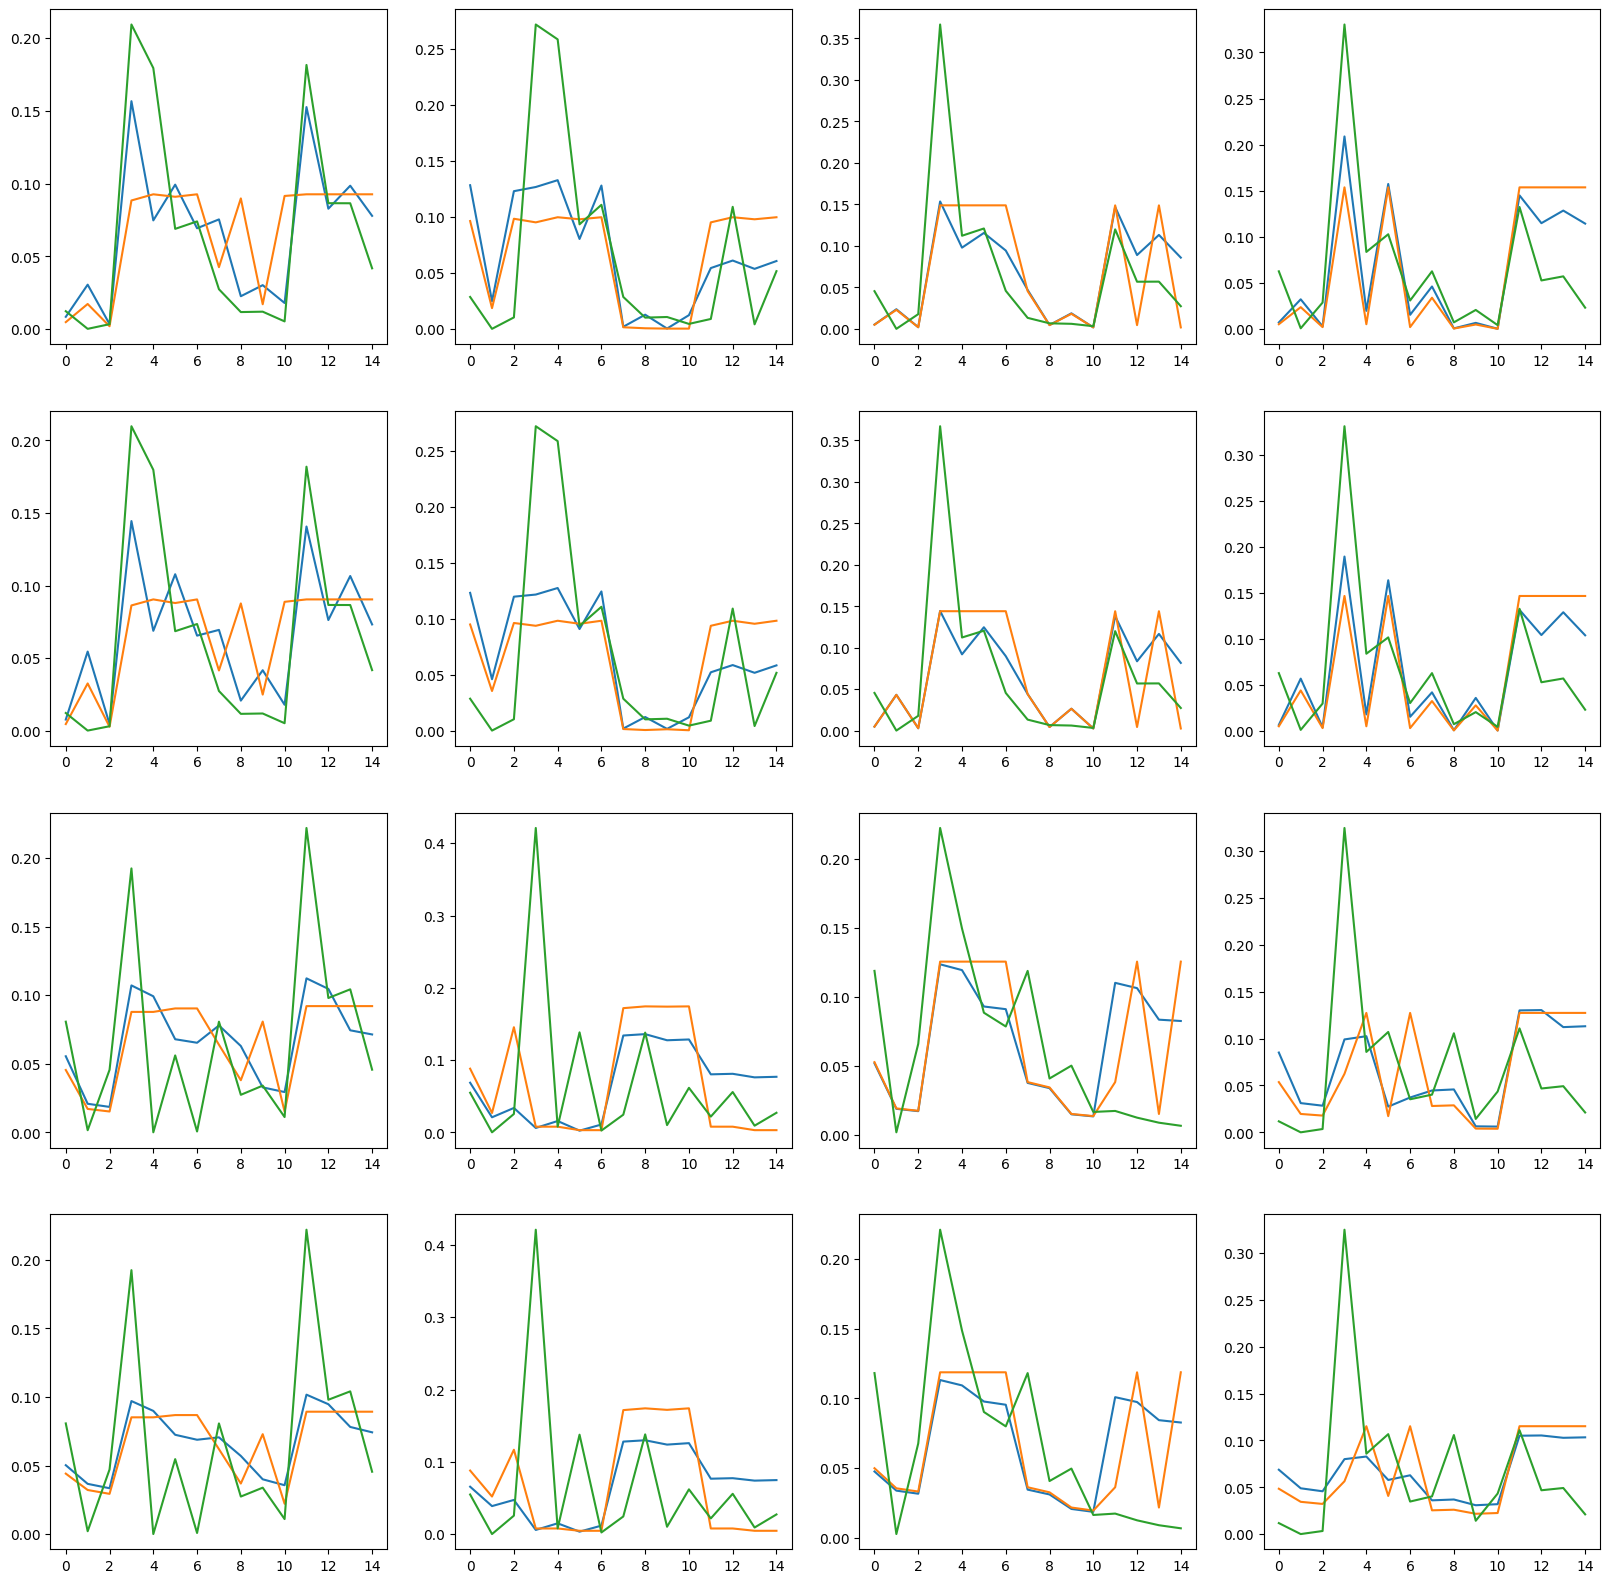

In [ ]:
fig, ax = plt.subplots(nrows=4, ncols=4,figsize=(20,20))

for ri,row in enumerate(ax):
    for ci,col in enumerate(row):
        col.plot(NSM_L[4*ri + ci])
        col.plot(NSM_2_L[4*ri + ci])
        col.plot(CESM_L[4*ri + ci])

In [ ]:
[explanations[exp] for exp in null_data[4]]

[[0, 2], [0, 2], [2], [2, 3]]

In [ ]:
[CESM_likelihood(possible_worlds[observation_worlds[i]],propositions[ad_c_num])[null_data[4][i]] for i in range(4)]

[0.179700353518248,
 0.1496207498016122,
 0.19241104840882267,
 0.11103922725130501]

In [ ]:
[CESM_likelihood(possible_worlds[observation_worlds[i]],propositions[ad_c_num])[explanation_data[i]] for i in range(4)]


[0.20971605537547527,
 0.22239841082027878,
 0.22189100116680383,
 0.3250273272507658]

In [ ]:
def compute_experiment_NSM_observations(prior,obs_data,exp_data,name='NSM'):
    if path.isfile(name+'.npy'):
        print('skipping ',name)
        return
    num_obs = len(obs_data)
    if num_obs != len(exp_data):
        return
    posteriors = np.zeros((num_obs+1,n_props))
    posteriors[0] = prior
    for i in range(num_obs):
        posteriors[i+1] = NSM_posterior(posteriors[i],obs_data[i],exp_data[i])
        np.save(name,posteriors)
    return posteriors

In [ ]:
[explanations[x] for x in null_data[3]]

[[0, 2], [0, 2], [2], [0, 3]]

## Rational Analysis of Inference from Explanation
number of observations necessary until the desired rule is in the MAP

In [ ]:
all_observations = [(wn,propositions[ad_c_num][wn]) for wn in range(16)]
all_CESM_explications = [np.argmax(CESM_likelihood(world,propositions[ad_c_num],N=10**3))  for world in possible_worlds]
all_NSM_CS = [np.argmax(NSM_likelihood(obs,propositions[ad_c_num]))  for obs in all_observations]

In [ ]:
np.array(all_NSM_CS)[observation_orderings[0]][:4]

array([ 3,  3, 11, 12])

In [ ]:
explanation_data

[3, 3, 11, 3]

In [ ]:
import os.path as path

In [ ]:
def compute_experiment_NSM_observations(prior,obs_data,exp_data,name='NSM'):
    if path.isfile(name+'.npy'):
        print('skipping ',name)
        return
    num_obs = len(obs_data)
    if num_obs != len(exp_data):
        return
    posteriors = np.zeros((num_obs+1,n_props))
    posteriors[0] = prior
    for i in range(num_obs):
        posteriors[i+1] = NSM_posterior(posteriors[i],obs_data[i],exp_data[i])
        np.save(name,posteriors)
    return posteriors

In [ ]:
compute_experiment_NSM_observations(even_prior,observation_data,explanation_data,name='NSM-CS-exp-s_0')

array([[1.52587891e-05, 1.52587891e-05, 1.52587891e-05, ...,
        1.52587891e-05, 1.52587891e-05, 1.52587891e-05],
       [5.93993558e-05, 5.89118542e-05, 5.31534798e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [ ]:
for idx,exp in enumerate(null_data):
    compute_experiment_NSM_observations(even_prior,observation_data,exp,name=f'NSM-AC-exp-{idx}')

skipping  NSM-AC-exp-0
skipping  NSM-AC-exp-1
skipping  NSM-AC-exp-2
skipping  NSM-AC-exp-3
skipping  NSM-AC-exp-4
skipping  NSM-AC-exp-5
skipping  NSM-AC-exp-6
skipping  NSM-AC-exp-7
skipping  NSM-AC-exp-8
skipping  NSM-AC-exp-9


In [ ]:
def plot_top_rules(data,element,obs_n=4,n=10000):
    (lambda l: element.plot(l[top_n(l,n)],markevery=np.where(top_n(l,n)==ad_c_num,True,False),marker='o',mfc='r',c='g'))(data[obs_n]/max(data[obs_n]))
    for ac in ac_data:
        (lambda l: element.plot(l[top_n(l,n)],markevery=np.where(top_n(l,n)==ad_c_num,True,False),marker='o',mfc='r',c='grey'))(ac[obs_n]/max(ac[obs_n]))

In [ ]:
NSM_exp = np.load('NSM-CS-exp-s_0.npy')
np.where(top_n(NSM_exp[4],10000) == ad_c_num)

(array([325]),)

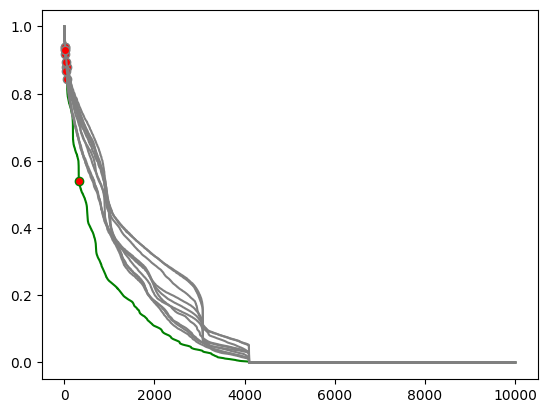

In [ ]:
fig,ax = plt.subplots()
plot_top_rules(NSM_exp,ax,4,10000)

In [ ]:
def var_worlds(var):
    world_nums = []
    for i,w in enumerate(possible_worlds):
        if w[var]:
            world_nums.append(i)
    return world_nums


def check_dependence(prop,w,vars):
    if prop[w] != prop[world_intervene(possible_worlds[w],[vars])[1]]:
            return 1
    return 0

def get_all_possible_explanations(prop):
    possible_exps = []
    for world in range(16):
        dependent_vars = []
        for var in range(4):
            if check_dependence(prop,world,var):
                dependent_vars.append(var)
        possible_exps.append(powerset(dependent_vars))
    return possible_exps        

NSM_possible_exps = [np.where(NSM_likelihood(obs,propositions[ad_c_num]) - (10.5**-1) >0)[0] for obs in all_observations]
NSM_actual_causes = [np.setdiff1d(x,[all_NSM_CS[idx]]+[0]) for idx,x in enumerate(NSM_possible_exps)]
print(np.prod([len(x) for x in NSM_actual_causes]))
NSM_actual_causes

147622500


[array([ 5, 11, 13]),
 array([2, 3, 6]),
 array([ 4,  5, 11, 13]),
 array([ 5, 11, 12, 13, 14]),
 array([ 5, 11, 13]),
 array([2, 3, 6]),
 array([ 5, 11, 13]),
 array([ 5, 11, 12, 13, 14]),
 array([ 3,  4, 12]),
 array([ 7,  9, 10]),
 array([ 4, 11, 12]),
 array([ 3,  4, 11, 13, 14]),
 array([3]),
 array([ 7,  9, 10]),
 array([ 4,  5,  6, 11, 12]),
 array([11, 13, 14])]

In [ ]:
def compute_experiment_NSM_AC(prior,obs_data,exp_data,batch):
    num_obs = len(obs_data)
    if num_obs != len(exp_data):
        return
    posteriors = np.zeros((num_obs+1,n_props))
    posteriors[0] = prior
    for i in range(num_obs):
        posteriors[i+1] = NSM_posterior(posteriors[i],obs_data[i],exp_data[i],s=0)
        np.save(f'NSM-AC-{batch}',posteriors)
    return posteriors

## Number of Observations until MAP

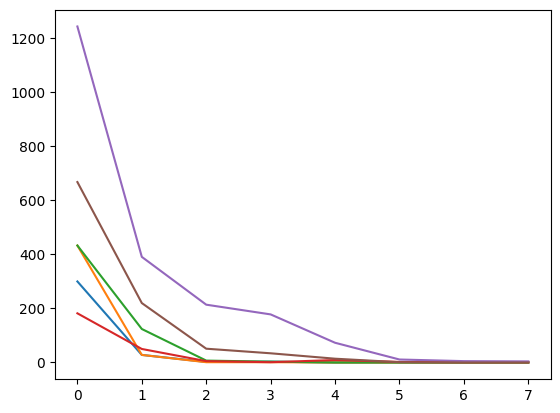

In [ ]:
cs_ranking = [np.where(top_n(cs_data[i],n_props)==ad_c_num)[0][0] for i in range(10)] 
ac_rankings = [[np.where(top_n(ac_data[batch][i],n_props)==ad_c_num)[0][0] for i in range(10)] for batch in range(len(NSM_AC_samples))]
plt.figure()
plt.plot(cs_ranking[2:])
for batch in range(len(NSM_AC_samples)):
    plt.plot(ac_rankings[batch][2:])

## Verifying order to see if the NSM captures a MAP within 5 observations

In [ ]:
observation_worlds = [4,10,12,15]
observation_orderings = [observation_worlds + list(np.roll(np.setdiff1d(range(16),observation_worlds),i)) for i in range(12)]

In [ ]:
def compute_experiment_NSM_observations(prior,obs_data,exp_data,batch):
    num_obs = len(obs_data)
    if num_obs != len(exp_data):
        return
    posteriors = np.zeros((num_obs+1,n_props))
    posteriors[0] = prior
    for i in range(num_obs):
        posteriors[i+1] = NSM_posterior(posteriors[i],obs_data[i],exp_data[i])
        np.save(f'NSM-CS-{batch}',posteriors)
        # if top_n(posteriors[i+1],1)[0] == ad_c_num:
        #     break
    return posteriors

In [ ]:
for idx,order in enumerate(observation_orderings):
    compute_experiment_NSM_observations(even_prior,
                                        obs_data=np.array(all_observations)[order],
                                        exp_data=np.array(all_NSM_CS)[order],
                                        batch=idx)                                    

It can with the experiment observations!!
Now we check to see how the AC explanatiosn do

In [ ]:
for idx,ac_sample in enumerate(NSM_AC_samples):
    compute_experiment_NSM_AC(even_prior,
                              obs_data=np.array(all_observations)[observation_orderings[0]],
                              exp_data=np.array(ac_sample)[observation_orderings[0]],
                              batch=idx)

In [ ]:
cs_data = np.load('NSM-CS-exp.npy')
ac_data = [np.load(f'NSM-AC-exp-{batch}.npy') for batch in range(7)]

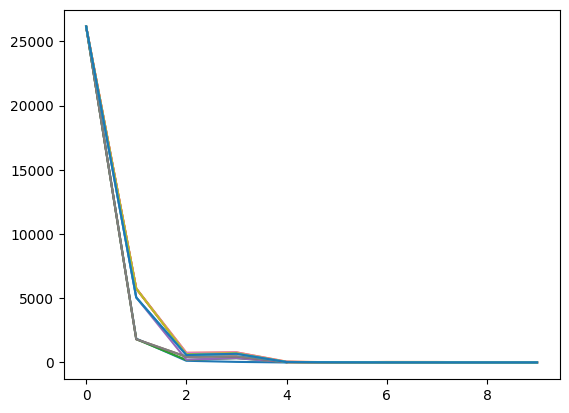

In [ ]:
cs_ranking = [np.where(top_n(cs_data[i],n_props)==ad_c_num)[0][0] for i in range(5)] 
ac_rankings = [[np.where(top_n(ac_data[batch][i],n_props)==ad_c_num)[0][0] for i in range(10)] for batch in range(len(NSM_AC_samples))]
plt.figure()
plt.plot(cs_ranking[:])
for batch in range(len(NSM_AC_samples)):
    plt.plot(ac_rankings[batch][:])

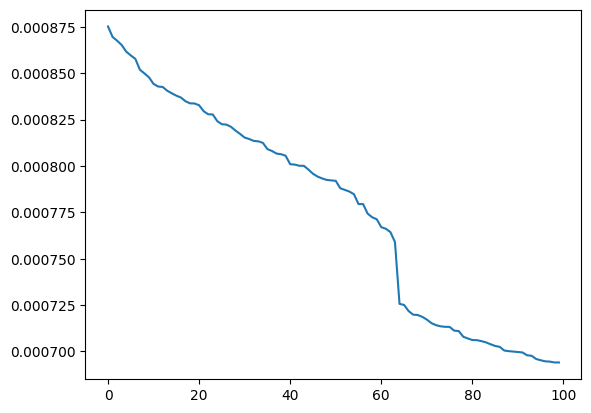

In [ ]:
(lambda l: plt.plot(l[top_n(l,100)]),)(x[4])

In [ ]:
def plot_top_rules(element,obs_n=4,n=10000):
    (lambda l: element.plot(l[top_n(l,n)],markevery=np.where(top_n(l,n)==ad_c_num,True,False),marker='o',mfc='r',c='g'))(cs_data[obs_n]/max(cs_data[obs_n]))
    for ac in ac_data:
        (lambda l: element.plot(l[top_n(l,n)],markevery=np.where(top_n(l,n)==ad_c_num,True,False),marker='o',mfc='r',c='grey'))(ac[obs_n]/max(ac[obs_n]))

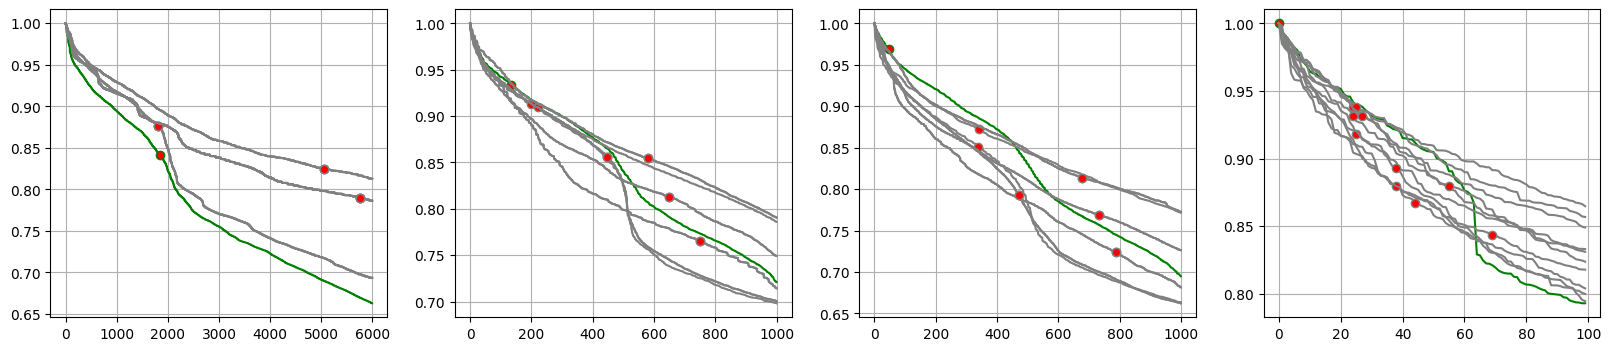

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=4,figsize=(20,4))

ranges = [6000,1000,1000,100]
for ci,col in enumerate(ax):
    plot_top_rules(col,ci+1,ranges[ci])
    col.grid()

fig.savefig('foo.pdf')

In [ ]:
cs_entropy = [entropy(posts) for posts in cs_data]
ac_entropy = [[entropy(posts) for posts in ac] for ac in ac_data]

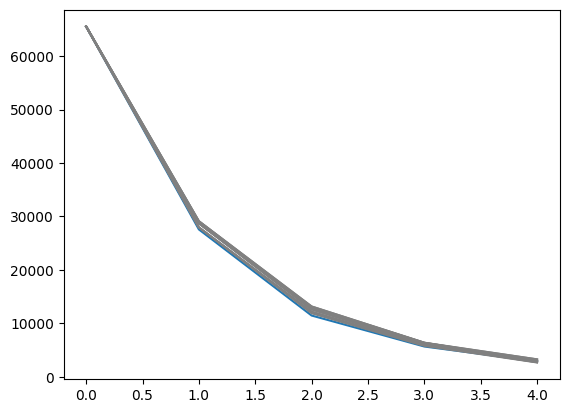

In [ ]:
fig, ax = plt.subplots()

ax.plot(np.exp(cs_entropy[:5]))
for ac in ac_entropy:
    ax.plot(np.exp(ac[:5]),c='grey')

## Evaluate score

In [ ]:
# cs_score = sum([sum(np.where(propositions[ad_c_num]==propositions[i],True,False))*prob  for i,prob in enumerate(cs_data[4])])
cs_score = sum([sum(np.where(propositions[ad_c_num]==propositions[i],True,False))*prob  for i,prob in enumerate(NSM_exp[4])])
ac_scores = [sum([sum(np.where(propositions[ad_c_num]==propositions[i],True,False))*prob  for i,prob in enumerate(data[4])]) for data in ac_data]

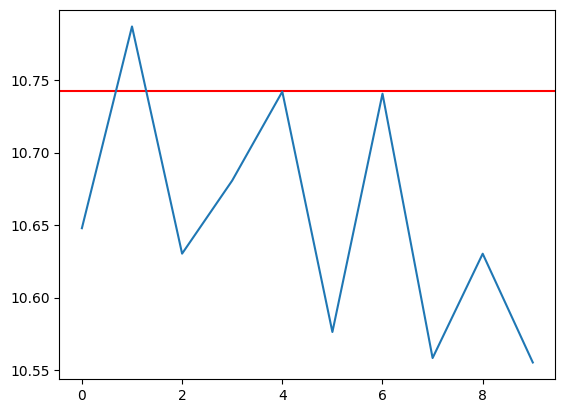

In [ ]:
plt.axhline(y = cs_score, color = 'r', linestyle = '-') 
plt.plot(ac_scores)